# load_data

In [1]:
import numpy as np 
import xlrd 
import torch 

def load_data(flag):
    file="./data1.xlsx"
    wb = xlrd.open_workbook(file) 
    sheet = wb.sheet_by_index(0) 
    
    num = 61  
    electronegativity = np.array([sheet.cell_value(loopi+1,1) for loopi in range(num)])
    d_electrons = np.array([sheet.cell_value(loopi+1,2) for loopi in range(num)])          
    group = np.array([sheet.cell_value(loopi+1,3) for loopi in range(num)])              
    radius = np.array([sheet.cell_value(loopi+1,4) for loopi in range(num)])              
    N_numbers = np.array([sheet.cell_value(loopi+1,5) for loopi in range(num)])      
    Ebar = np.array([sheet.cell_value(loopi+1,6) for loopi in range(27)])
    
    
    X_data = np.stack((electronegativity, d_electrons, group, radius, N_numbers), axis=0).T 
    X_data = torch.from_numpy(X_data).float()  
    
    if flag == "E": 
        y_data = torch.from_numpy(Ebar).float() 
    
    return X_data, y_data, [electronegativity, d_electrons, group, radius, N_numbers, y_data] 

    
def build_dataset(flag):
    X_data, y_data, _ = load_data(flag)
    
    train_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26] 
    
    test_list = [2, 5, 14, 20, 25]  

        
    for idx in test_list: 
        train_list.remove(idx)
    
    predict_list = [27+loopi for loopi in range(34)]
    
    X_data_train, y_data_train = [], []
    X_data_test, y_data_test = [], [] 
    X_data_predict = [] 
    for index in range(61):  
        if index in train_list:
            X_data_train.append(X_data[index,:].reshape(1,1,5))
            y_data_train.append(y_data[index].reshape(1)) 
            
        if index in test_list: 
            X_data_test.append(X_data[index,:].reshape(1,1,5))
            y_data_test.append(y_data[index].reshape(1)) 
            
        if index in predict_list:
            X_data_predict.append(X_data[index,:].reshape(1,1,5)) 
            
    return X_data_train, y_data_train, X_data_test, y_data_test, X_data_predict


if __name__ == "__main__": 
    flag = "E" 
    X_data_train, y_data_train, X_data_test, y_data_test, X_data_predict = build_dataset(flag) 

In [3]:
import torch  
import torch.nn.functional as F 
import matplotlib.pyplot as plt 

class MyLoss(torch.nn.Module): 
    def __init__(self):
        super(MyLoss, self).__init__() 
        
    def forward(self, pred, real): 
        return torch.mean(torch.abs(torch.sub(pred, real)))
    
    
class MyError(torch.nn.Module): 
    def __init__(self):
        super(MyError, self).__init__() 
        
    def forward(self, pred, real): 
        return torch.mean(torch.abs(torch.sub(pred, real) / real)) 
    
    
class Conv1d_same_padding(torch.nn.Module):
    def __init__(self, inplanes, planes, kernel_size, strides=1, dilation=1):
        super(Conv1d_same_padding, self).__init__() 
        self.kernel_size = kernel_size
        self.strides = strides
        self.dilation = dilation
        self.conv1d = torch.nn.Conv1d(inplanes, planes, kernel_size, strides, bias=False) 
        torch.nn.init.xavier_uniform_(self.conv1d.weight)

    def forward(self, x): 
        input_rows = x.size(2)
        out_rows = (input_rows + self.strides - 1) // self.strides
        padding_rows = max(0, (out_rows - 1) * self.strides + (self.kernel_size - 1) * self.dilation + 1 - input_rows) 
        x = F.pad(x, pad=(0, padding_rows), mode="constant") 
        outputs = self.conv1d(x)        
        return outputs
    

def plot_training_rst(error_rec_train, error_rec_test):
    plt.figure(figsize=(10,9)) 
    plt.plot(error_rec_train, "-o", linewidth=3, markersize=8) 
    plt.plot(error_rec_test, "-o", linewidth=3, markersize=8) 
    plt.ylim([0,1]) 
    plt.legend(["Train error", "Test error"], fontsize=20) 
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Epoch", fontsize=18) 
    plt.ylabel("Error", fontsize=18) 
    plt.grid(which="both", linestyle="--", linewidth=2, axis='y')
    plt.show() 

In [4]:
import sys 
#sys.path.append("./utils/")
print(sys.path)

import os 
import shutil 

import torch  
import numpy as np 

save_path = "./save_results/"
if os.path.exists(save_path): 
    shutil.rmtree(save_path)
os.mkdir(save_path)

['C:\\Users\\lenovo\\Desktop\\data\\改group\\1-换test', 'D:\\Ana\\python38.zip', 'D:\\Ana\\DLLs', 'D:\\Ana\\lib', 'D:\\Ana', '', 'D:\\Ana\\lib\\site-packages', 'D:\\Ana\\lib\\site-packages\\locket-0.2.1-py3.8.egg', 'D:\\Ana\\lib\\site-packages\\win32', 'D:\\Ana\\lib\\site-packages\\win32\\lib', 'D:\\Ana\\lib\\site-packages\\Pythonwin', 'D:\\Ana\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\lenovo\\.ipython']


In [5]:
flag = "E" 
X_data_train, y_data_train, X_data_test, y_data_test, X_data_predict = build_dataset(flag)  

# model

In [7]:
import torch  
import torch.nn.functional as F 
#from utils import Conv1d_same_padding 
#from load_data import load_data

class Net(torch.nn.Module): 
    def __init__(self, flag): 
        super(Net, self).__init__() 
        X_data, _, _ = load_data("E")
        self.conv_0 = Conv1d_same_padding( 4, 16, 1)
        self.conv_1 = Conv1d_same_padding(16, 16, 1) 
        self.conv_2 = Conv1d_same_padding(16, 16, 1) 
        self.conv_3 = Conv1d_same_padding(16, 16, 1) 
        self.conv_4 = Conv1d_same_padding(16,  8, 1) 
        self.dense_0 = torch.nn.Linear(40, 32, bias=False) 
        self.dense_1 = torch.nn.Linear(32, 16, bias=False) 
        self.dense_2 = torch.nn.Linear(16, 1, bias=False)
        torch.nn.init.xavier_uniform_(self.dense_0.weight) 
        torch.nn.init.xavier_uniform_(self.dense_1.weight) 
        torch.nn.init.xavier_uniform_(self.dense_2.weight) 
        
        self.data = X_data 
        self.flag = flag 
        
    def forward(self, x): 
        if self.flag == "E":
            label_0 = self.data[ 3,:].reshape(1,1,5).float()   
            label_1 = self.data[ 4,:].reshape(1,1,5).float()   
            label_2 = self.data[13,:].reshape(1,1,5).float()   
        net = torch.cat([x, label_0, label_1, label_2], dim=1) 
        
        net = F.relu(self.conv_0(net))  
        net = F.relu(self.conv_1(net))  
        net = F.relu(self.conv_2(net))  
        net = F.relu(self.conv_3(net))  
        net = F.relu(self.conv_4(net))  
        net = torch.flatten(net)  
        
        net = F.relu(self.dense_0(net)) 
        # net = self.dropout_0(net)
        net = F.relu(self.dense_1(net)) 
        # net = self.dropout_1(net)
        outputs = self.dense_2(net) 
        return outputs 


if __name__ == "__main__":
    model = Net("E") 
    coord_tensor = torch.randn([1,1,5]) 
    result = model(coord_tensor) 
    print(result.shape) 

torch.Size([1])


# train

In [8]:
def train_func(flag): 
    
    # ========== Training parameters setting ========== 
    X_data_train, y_data_train, X_data_test, y_data_test, X_data_predict = build_dataset(flag) 
    epochs, init_lr = 120, 1e-3 
    model = Net(flag) 
    cal_loss, cal_error = torch.nn.MSELoss(), MyError() 
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr) 
    
    # ========== start training ========== 
    loss_rec_train, loss_rec_test = [], [] 
    error_rec_train, error_rec_test = [], [] 
    for epoch in range(epochs): 
        
        # ========== Training ========== 
        train_loss, train_error = 0, 0
        model.train() 
        index = 0
        for coord, labels in zip(X_data_train, y_data_train): 
            optimizer.zero_grad()                 
            outputs = model(coord)                 
            loss = cal_loss(outputs, labels)      
            error = cal_error(outputs, labels)    
            loss.backward()                       
            optimizer.step()                      
            train_loss += loss.item()             
            train_error += error.item()           
            index += 1 
            
        train_loss_mean, train_error_mean = (train_loss / index), (train_error / index)
        loss_rec_train.append(train_loss_mean)
        error_rec_train.append(train_error_mean) 
        
        # ========== Testing ========== 
        test_loss, test_error = 0, 0 
        model.eval() 
        with torch.no_grad(): 
            index = 0 
            for coord, labels in zip(X_data_test, y_data_test):
                outputs = model(coord)             
                loss = cal_loss(outputs, labels)   
                error = cal_error(outputs, labels) 
                test_loss += loss.item()            
                test_error += error.item()         
                index += 1
                
        test_loss_mean, test_error_mean = (test_loss / index), (test_error / index)
        loss_rec_test.append(test_loss_mean) 
        error_rec_test.append(test_error_mean)
    
    return loss_rec_train, error_rec_train, loss_rec_test, error_rec_test, model

In [9]:
import time
start_time = time.time()

loop_num = 1000
error_flag_test = 1e20    
for train_num in range(loop_num): 
    loss_rec_train, error_rec_train, loss_rec_test, error_rec_test, model = train_func(flag) 
    if error_rec_test[-1] <= error_flag_test: 
        error_flag_train = error_rec_train[-1] # update the error flag
        error_flag_test = error_rec_test[-1]   # update the error flag
        train_error = error_rec_train          # update the training error
        test_error = error_rec_test            # update the testing error
        model_sav = model 
        
        print("{ "+str(train_num)+" }", "Now the best model's testing error is", "%.5f" % error_flag_test)
        
end_time = time.time()
used_time = end_time - start_time
print(used_time)

{ 0 } Now the best model's testing error is 0.61577
{ 1 } Now the best model's testing error is 0.59744
{ 2 } Now the best model's testing error is 0.48351
{ 7 } Now the best model's testing error is 0.47145
{ 26 } Now the best model's testing error is 0.36938
{ 65 } Now the best model's testing error is 0.24994
{ 91 } Now the best model's testing error is 0.23461
{ 899 } Now the best model's testing error is 0.20366
3963.256255865097


In [10]:
train_eval = [] # training evaluation 
elements = ["Sc_2", "Ti_2", "Cr_2", "Co_2", "Zr_2", "Hf_2", "Ir_2", 
            "V_3", "Ni_3", "Cu_3", "Zn_3",  "Ru_3", "Ag_3", "Cd_3", 
            "Ir_3", "Ti_4", "Mn_4", "Co_4", "Ni_4", "Cu_4", "Zn_4", "Os_4",]

model_sav.eval() 
with torch.no_grad():
    for coord in X_data_train:
        outputs = model_sav(coord)
        train_eval.append(outputs.detach().numpy()) 
        
print("Prediction in training dataset", "\n") 
index = 0
for element in elements:
    print(element, train_eval[index])
    index += 1 

Prediction in training dataset 

Sc_2 [1.1684256]
Ti_2 [2.4270763]
Cr_2 [1.5897409]
Co_2 [5.3496]
Zr_2 [1.8851249]
Hf_2 [1.8317976]
Ir_2 [3.0548513]
V_3 [0.71169376]
Ni_3 [10.314186]
Cu_3 [12.837125]
Zn_3 [7.735251]
Rh_3 [3.428987]
Ag_3 [12.891241]
Cd_3 [7.652857]
Ir_3 [3.5762935]
Ti_4 [0.44371617]
Fe_4 [1.7149296]
Co_4 [7.813198]
Ni_4 [12.00988]
Cu_4 [13.761828]
Ru_4 [8.695411]
Os_4 [3.5105882]


In [11]:
elements = ["V_2", "Y_2", "Rh_3", "Fe_4", "Ru_4"]
test_eval = [] 
model_sav.eval() 
with torch.no_grad(): 
    for coord in X_data_test:
        outputs = model_sav(coord)
        test_eval.append(outputs) 
        
print("Prediction in testing dataset", "\n") 
index = 0
for element in elements:
    print(element, test_eval[index])
    index += 1 

Prediction in testing dataset 

V_2 tensor([2.2950])
Y_2 tensor([0.8556])
Ru_3 tensor([7.0461])
Mn_4 tensor([5.0433])
Zn_4 tensor([5.7154])


In [12]:
elements = ["Mn_2", "Fe_2", "Ni_2", "Cu_2", "Zn_2", "Ru_2", 
            "Rh_2", "Pd_2", "Ag_2", "Cd_2", "Os_2", "Pt_2", 
            "Au_2", "Sc_3", "Ti_3", "Cr_3", "Mn_3", "Fe_3", 
            "Co_3", "Y_3", "Pd_3", "Hf_3", "Os_3", "Pt_3", 
            "Au_3", "Sc_4", "V_4", "Cr_4", "Y_4", "Rh_4", 
            "Pd_4", "Cd_4", "Ir_4", "Pt_4"]

predicts = [] 
model_sav.eval() 
with torch.no_grad():
    for coord in X_data_predict:
        outputs = model_sav(coord)
        predicts.append(outputs) 
        
print("Prediction in testing dataset", "\n") 
index = 0
for element in elements:
    print(element, predicts[index])
    index += 1         

Prediction in testing dataset 

Mn_2 tensor([0.5602])
Fe_2 tensor([2.3542])
Ni_2 tensor([9.3963])
Cu_2 tensor([11.8933])
Zn_2 tensor([6.7915])
Ru_2 tensor([2.7413])
Rh_2 tensor([6.5405])
Pd_2 tensor([14.5652])
Ag_2 tensor([11.9475])
Cd_2 tensor([6.7091])
Os_2 tensor([0.5365])
Pt_2 tensor([10.4559])
Au_2 tensor([11.1017])
Sc_3 tensor([0.5312])
Ti_3 tensor([1.1425])
Cr_3 tensor([0.9851])
Mn_3 tensor([1.0767])
Fe_3 tensor([2.8756])
Co_3 tensor([5.8710])
Y_3 tensor([0.1404])
Pd_3 tensor([15.3835])
Hf_3 tensor([0.2963])
Os_3 tensor([1.2241])
Pt_3 tensor([10.9480])
Au_3 tensor([12.0085])
Sc_4 tensor([0.3291])
V_4 tensor([-0.8422])
Cr_4 tensor([-0.2210])
Y_4 tensor([0.0256])
Rh_4 tensor([8.9883])
Pd_4 tensor([16.7564])
Cd_4 tensor([8.5776])
Ir_4 tensor([5.5184])
Pt_4 tensor([12.8563])


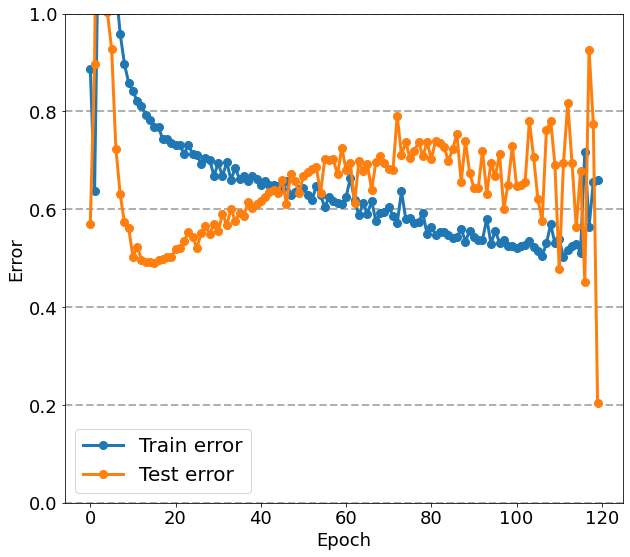

<ipython-input-13-7efe6c1c81a8>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.savetxt(save_path+"ML_results_"+flag+"_preditions.txt", np.array(predicts))
<ipython-input-13-7efe6c1c81a8>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.savetxt(save_path+"ML_results_"+flag+"_preditions.txt", np.array(predicts))
<ipython-input-13-7efe6c1c81a8>:4: FutureWarning

In [13]:
plot_training_rst(train_error, test_error) 
np.savetxt(save_path+"ML_results_"+flag+"_preditions.txt", np.array(predicts)) 
np.savetxt(save_path+"ML_results_"+flag+"_train.txt", np.array(train_eval)) 
np.savetxt(save_path+"ML_results_"+flag+"_test.txt", np.array(test_eval)) 
torch.save(model_sav.state_dict(), save_path+"atomic_net_"+flag+".pkl")